In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import math
np.math=math #to avoid issues in 'pulse' script with new numpy

import torch
import torch.optim as optim

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random
import copy


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as models_rf

import data_utils.data_analysis as data_analysis

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [3]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

## Loading the dataset

In [4]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [5]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [6]:
df_input.describe()

,shot number,order2,order3,order4,goodness
count,9503.000000,9503.000000,9503.000000,9.503000e+03,9503.000000
mean,167916.696412,34900.021046,2500.789224,-4.749921e+06,1.185132
std,2743.790366,316.254388,15565.830169,5.123437e+05,0.217978
min,163165.000000,34400.000000,-23000.000000,-5.500000e+06,0.663816
25%,165540.500000,34600.000000,-11000.000000,-5.200000e+06,1.024159
50%,167917.000000,34900.000000,4000.000000,-4.600000e+06,1.135635
75%,170292.500000,35200.000000,16000.000000,-4.300000e+06,1.345186
max,172668.000000,35400.000000,28000.000000,-4.000000e+06,1.941571


### Pulse reconstruction

In [7]:
#time in fs (it is the boundary)
#using DASK to accelerate computing
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [8]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [9]:
filename_pulse='datasets/pulse_240918.h5'

In [10]:
#read the data
df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots with bad goodness

In [11]:
goodness_val=1.3
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]
df_spec_freq_reduced=df_spec_freq.iloc[good_shots_list]
df_spec_int_reduced=df_spec_int.iloc[good_shots_list]
df_spec_phase_reduced=df_spec_phase.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)
df_spec_freq_reduced.reset_index(inplace=True,drop=True)
df_spec_int_reduced.reset_index(inplace=True,drop=True)
df_spec_phase_reduced.reset_index(inplace=True,drop=True)

In [12]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163188,34400.0,-23000.0,-4900000.0,1.418891
3,163189,34400.0,-23000.0,-4600000.0,1.335844
4,163192,34400.0,-23000.0,-4600000.0,1.333817
...,...,...,...,...,...
2711,172480,35400.0,19000.0,-5500000.0,1.330710
2712,172481,35400.0,19000.0,-5500000.0,1.365691
2713,172482,35400.0,19000.0,-5500000.0,1.357783
2714,172483,35400.0,19000.0,-5500000.0,1.319961


In [13]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

### Plot goodness

In [14]:
#reference values
beta2=35000
beta3=0
beta4=-4.5e6

In [15]:
#define a set with the bad goodness shots
df_input_bad=df_input[df_input['goodness']<goodness_val]

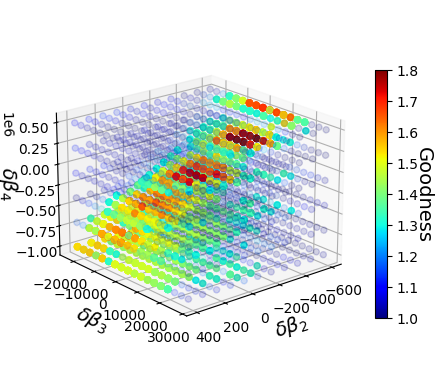

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_reduced['order2']-beta2, df_input_reduced['order3']-beta3, df_input_reduced['order4']-beta4,c=df_input_reduced['goodness'],
                    cmap='jet',vmin=1.0,vmax=1.8)
ax.scatter(df_input_bad['order2']-beta2, df_input_bad['order3']-beta3, df_input_bad['order4']-beta4,c=df_input_bad['goodness'],
                    cmap='jet',vmin=1.0,vmax=1.8,alpha=0.02)
ax.set_xlabel(r'$\delta\beta_2$',fontsize=14)
ax.set_ylabel(r'$\delta\beta_3$',fontsize=14)
ax.set_zlabel(r'$\delta\beta_4$',fontsize=14)
ax.view_init(elev=20., azim=50)
#plt.title('Goodness')
cbar = plt.colorbar(plot_3d,fraction=0.025, pad=-0.01)
cbar.ax.set_ylabel('Goodness', rotation=270,labelpad=10,fontsize=14)
ax.set_box_aspect(None, zoom=0.85)
plt.show()
#crop the figure with any online tool to remove the boundaries

# Forward model

In [17]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


### Forwrd Linear model

In [18]:
def train_lin_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    forward_model_lin=LinearRegression().fit(X_train,y_train)

    y_predict_forward=forward_model_lin.predict(X_test)
    
    #study the erro distribution
    df_error_forward_lin=abs(y_test_reset-y_predict_forward)
    df_error_forward_lin=df_error_forward_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
    
    
    return forward_model_lin, df_error_forward_lin

In [19]:
forward_model_lin,df_error_forward_lin=train_lin_forward(X_train, X_test, y_train, y_test)

### Forward Random Forest

In [20]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

In [21]:
%%time
forward_model_rf,df_error_forward_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 3.47 s, sys: 126 ms, total: 3.6 s
Wall time: 3.05 s


### Multi-layer Perceptron (MLP)

In [22]:
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.0452611967921257
Finished epoch 20,latest loss 0.0010191722540184855
Finished epoch 40,latest loss 0.0006389676127582788
Finished epoch 60,latest loss 0.0005351686268113554
Finished epoch 80,latest loss 0.0004840385518036783
Finished epoch 99,latest loss 0.0004544917610473931
Total time taken to train the model: 14.51s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

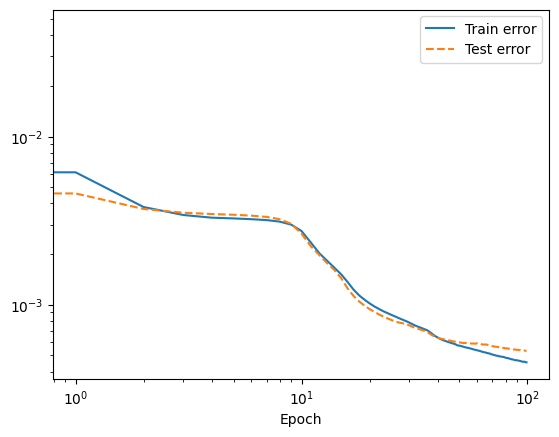

In [23]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Script dispersion method

In [24]:
def shift_pulse(p):
    #shift the pulse so the peak is at thr center of the array
    return np.roll(p,int(len(p)/2)-np.argmax(p))

In [25]:
%%time
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#for example 168758
shot_ftl=168758
ref_index=df_input_reduced[df_input_reduced['shot number']==shot_ftl].index.values[0]

time=150
time_bins=200
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
c = 299792458 ## speed of light in m/s
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
intensity=df_spec_int_reduced.loc[ref_index].to_numpy()
frequency=df_spec_freq_reduced.loc[ref_index].to_numpy()
phase=df_spec_phase_reduced.loc[ref_index].to_numpy()
p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
p_2 =copy.deepcopy(p_ref)

#get the dispersion values from this reference shot
o2_ref=df_input_reduced.loc[ref_index]['order2']
o3_ref=df_input_reduced.loc[ref_index]['order3']
o4_ref=df_input_reduced.loc[ref_index]['order4']

script_error=[]
for shot_j in range(len(df_input_reduced)):
    p_2 =copy.deepcopy(p_ref) #fresh copy every time
    #desired pulse
    #shot_j=50
    o2_final=df_input_reduced.loc[shot_j]['order2']
    o3_final=df_input_reduced.loc[shot_j]['order3']
    o4_final=df_input_reduced.loc[shot_j]['order4']

    #add dispersion
    p_2.dispersion(2,o2_final-o2_ref)
    p_2.dispersion(3,o3_final-o3_ref)
    p_2.dispersion(4,o4_final-o4_ref)

    #shift the pulses so the peak at the center
    p2_s=shift_pulse(p_2.intensity)
    pmeas_s=shift_pulse(df_pulse_200_reduced.iloc[shot_j]) #measured shot 

    #mae error
    error=abs(p2_s-pmeas_s)
    error=error.sum()/len(p2_s)
    script_error.append(error)
script_error=np.array(script_error)

CPU times: user 1min 19s, sys: 1.93 ms, total: 1min 19s
Wall time: 1min 19s


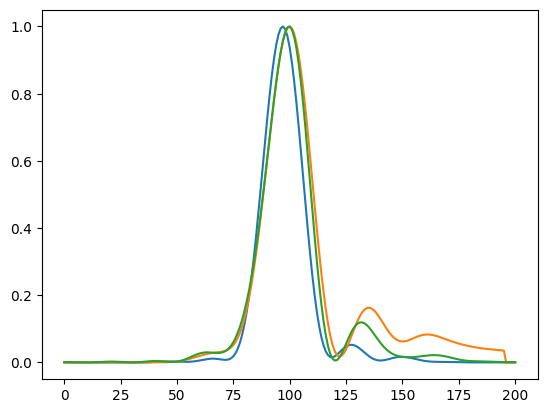

In [26]:
plt.plot(p_ref.intensity)
plt.plot(p2_s)
plt.plot(pmeas_s)

### Predictions

Text(0, 0.5, 'Intensity')

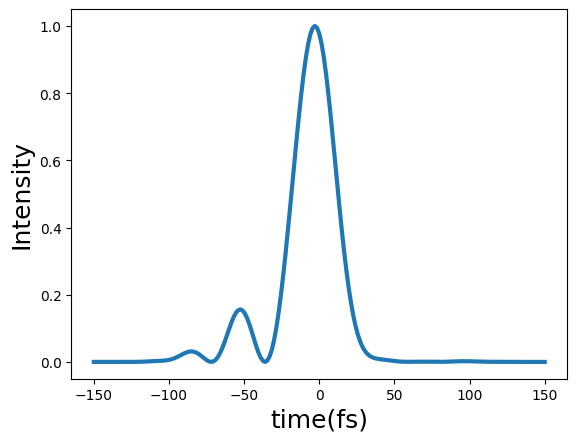

In [27]:
shot_index=35
plt.plot(df_time_200,y_test.iloc[shot_index],linewidth=3)
plt.xlabel('time(fs)',fontsize=18)
plt.ylabel('Intensity',fontsize=18)

In [28]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_lin,forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_lin=forward_model_lin.predict(X_values)
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_lin[0],label='Prediction (Linear)',linewidth=3,linestyle='-')
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')

    mae_lin=abs(y_test.iloc[shot_index]-y_predict_forward_lin[0])
    mae_lin=mae_lin.sum()/len(y_test.iloc[shot_index])
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.7,r'$MAE_{{Lin}}={:.1f}$%'.format(100*mae_lin))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

In [29]:
def plot_example_wth_script(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_lin,forward_model_rf,forward_model_mlp,
                            shot_ftl,df_spec_int,df_spec_freq,df_spec_phase):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_lin=forward_model_lin.predict(X_values)
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)

    #built the reference pulse with the script
    #shot_ftl=168758
    ref_index=df_input[df_input['shot number']==shot_ftl].index.values[0]

    #get the dispersion values from this reference shot
    o2_ref=df_input.loc[ref_index]['order2']
    o3_ref=df_input.loc[ref_index]['order3']
    o4_ref=df_input.loc[ref_index]['order4']

    time=int(df_time_val.max())#150
    time_bins=len(df_time_val)-1#200
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    intensity=df_spec_int.loc[ref_index].to_numpy()
    frequency=df_spec_freq.loc[ref_index].to_numpy()
    phase=df_spec_phase.loc[ref_index].to_numpy()
    p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)

    #add dispersion
    p_ref.dispersion(2,order2-o2_ref)
    p_ref.dispersion(3,order3-o3_ref)
    p_ref.dispersion(4,order4-o4_ref)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,p_ref.intensity,label='Script',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_lin[0],label='Prediction (Linear)',linewidth=3,linestyle='-')
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')

    mae_lin=abs(y_test.iloc[shot_index]-y_predict_forward_lin[0])
    mae_lin=mae_lin.sum()/len(y_test.iloc[shot_index])
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.7,r'$MAE_{{Lin}}={:.1f}$%'.format(100*mae_lin))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

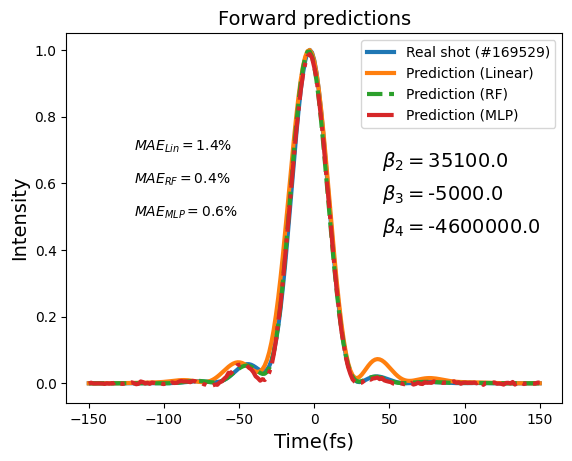

In [30]:
shot_index=75
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

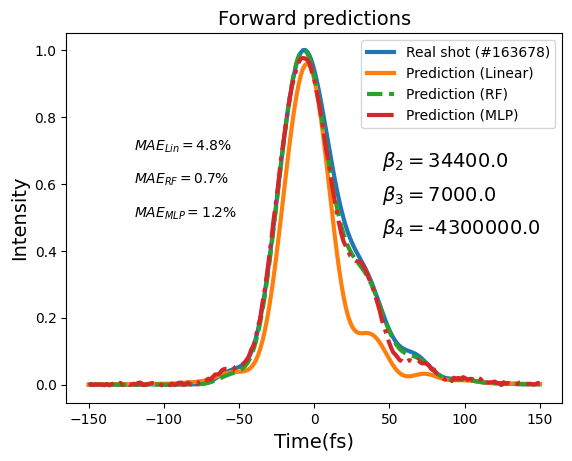

In [31]:
shot_index=512
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

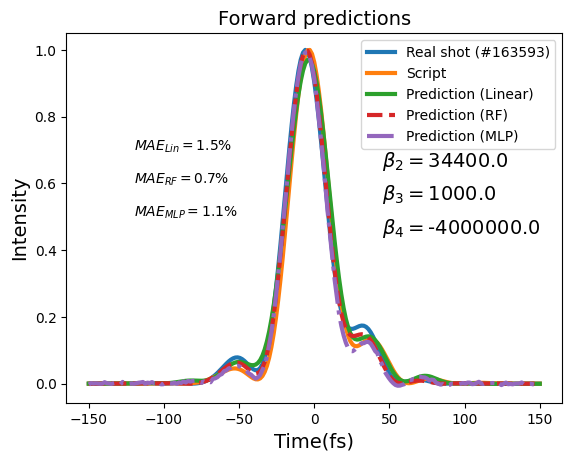

In [32]:
shot_index=510
plot_example_wth_script(shot_index,X_test,y_test,df_input_reduced,df_time_200,
                 forward_model_lin,forward_model_rf,forward_model_mlp,
                            168758,#reference shot
                        df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)

/tmp/ipykernel_109847/617153583.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'Model Accuracy (Forward)')

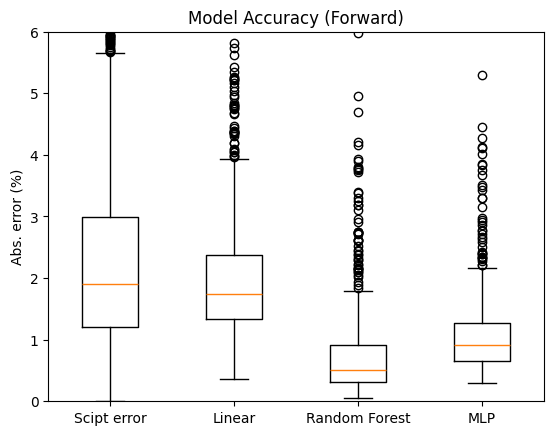

In [33]:
error_dist=[100*script_error,
            100*df_error_forward_lin,
            100*df_error_forward_rf,
           100*error_fwd_model_mlp]
labels=['Scipt error','Linear','Random Forest','MLP']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')

       Analytic    Linear        RF       MLP
0     10.572439  1.816867  0.339681  0.659057
1      7.685112  1.268100  0.260936  0.559445
2      7.530497  2.881495  3.897119  3.840073
3      5.689584  3.450849  1.187995  2.038574
4      5.241778  0.957061  0.627136  0.847604
...         ...       ...       ...       ...
2711   2.519960       NaN       NaN       NaN
2712   2.444384       NaN       NaN       NaN
2713   2.545545       NaN       NaN       NaN
2714   2.472945       NaN       NaN       NaN
2715   2.440944       NaN       NaN       NaN

[2716 rows x 4 columns]


(0.0, 5.0)

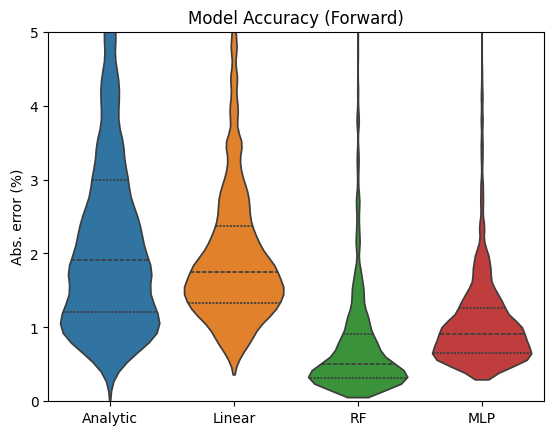

In [34]:
df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=False,orient='v')
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.ylim(0,5)

       Analytic    Linear        RF       MLP
0     10.572439  1.816867  0.339681  0.659057
1      7.685112  1.268100  0.260936  0.559445
2      7.530497  2.881495  3.897119  3.840073
3      5.689584  3.450849  1.187995  2.038574
4      5.241778  0.957061  0.627136  0.847604
...         ...       ...       ...       ...
2711   2.519960       NaN       NaN       NaN
2712   2.444384       NaN       NaN       NaN
2713   2.545545       NaN       NaN       NaN
2714   2.472945       NaN       NaN       NaN
2715   2.440944       NaN       NaN       NaN

[2716 rows x 4 columns]


(0.0, 5.0)

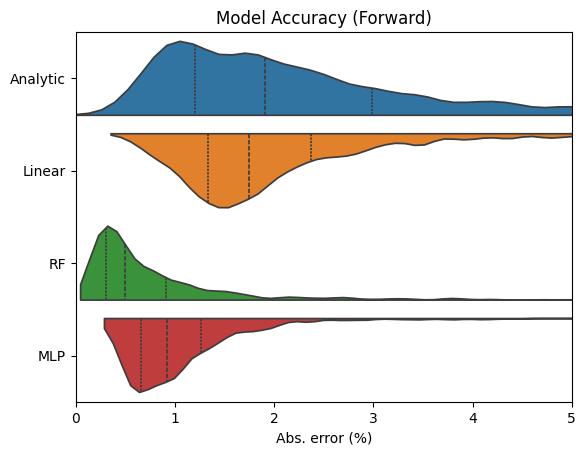

In [35]:
df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)

## Impact of shot averaging on models

In [36]:
#Average shots with same input param
def shot_average(df_input,df_time,df_spec_freq,df_spec_int,df_spec_phase):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    goodness_mean=[]
    wizz_mean=[]
    freq_mean=[]
    int_mean=[]
    phase_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            freq_list=df_spec_freq.iloc[index].to_numpy()
            int_list=df_spec_int.iloc[index].to_numpy()
            phase_list=df_spec_phase.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                freq_list=np.vstack([freq_list,df_spec_freq.iloc[index].to_numpy()])
                int_list=np.vstack([int_list,df_spec_int.iloc[index].to_numpy()])
                phase_list=np.vstack([phase_list,df_spec_phase.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                freq_mean.append(np.mean(freq_list,axis=0))
                int_mean.append(np.mean(int_list,axis=0))
                phase_mean.append(np.mean(phase_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                freq_list=df_spec_freq.iloc[index].to_numpy()
                int_list=df_spec_int.iloc[index].to_numpy()
                phase_list=df_spec_phase.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()    
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    df_input_avg['goodness mean']=goodness_mean
    df_time_avg=pd.DataFrame(wizz_mean)
    df_spec_freq_avg=pd.DataFrame(freq_mean)
    df_spec_int_avg=pd.DataFrame(int_mean)
    df_spec_phase_avg=pd.DataFrame(phase_mean)
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg,df_spec_freq_avg,df_spec_int_avg,df_spec_phase_avg

In [37]:
#AVG pulses
df_input_avg,df_pulse_200_avg,df_spec_freq_avg,df_spec_int_avg,df_spec_phase_avg=shot_average(df_input,df_pulse_200,df_spec_freq,df_spec_int,df_spec_phase)

In [38]:
print(len(df_input_avg))
print(len(df_pulse_200_avg))

1187
1187


In [39]:
#Drop the avg shots with low goodness
df_input_avg=df_input_avg[df_input_avg['goodness mean']>goodness_val]

good_shots_list=df_input_avg.index.values
#print(good_shots_list)
df_pulse_200_avg=df_pulse_200_avg.iloc[good_shots_list]
df_spec_freq_avg=df_spec_freq_avg.iloc[good_shots_list]
df_spec_int_avf=df_spec_int_avg.iloc[good_shots_list]
df_spec_phase_avg=df_spec_phase_avg.iloc[good_shots_list]

#reset the index
df_input_avg.reset_index(inplace=True,drop=True)
df_pulse_200_avg.reset_index(inplace=True,drop=True)
df_spec_freq_avg.reset_index(inplace=True,drop=True)
df_spec_int_avg.reset_index(inplace=True,drop=True)
df_spec_phase_avg.reset_index(inplace=True,drop=True)

In [40]:
print(df_input_avg)
print(df_pulse_200_avg)

      order2   order3     order4  goodness mean
0    34400.0 -20000.0 -4900000.0       1.319798
1    34400.0 -20000.0 -4600000.0       1.391051
2    34400.0 -17000.0 -4600000.0       1.394367
3    34400.0 -14000.0 -4600000.0       1.393152
4    34400.0 -14000.0 -4000000.0       1.329165
..       ...      ...        ...            ...
334  35400.0  13000.0 -5500000.0       1.405947
335  35400.0  13000.0 -5200000.0       1.366808
336  35400.0  16000.0 -5500000.0       1.397036
337  35400.0  16000.0 -5200000.0       1.301449
338  35400.0  19000.0 -5500000.0       1.351403

[339 rows x 4 columns]
          0         1         2         3         4         5         6    \
0    0.005789  0.005827  0.005896  0.006020  0.006218  0.006499  0.006865   
1    0.000397  0.000421  0.000448  0.000479  0.000515  0.000556  0.000601   
2    0.001926  0.002018  0.002113  0.002214  0.002326  0.002453  0.002602   
3    0.001924  0.002006  0.002097  0.002201  0.002319  0.002454  0.002605   
4    0.000796  

In [41]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train_avg, X_test_avg, y_train_avg, y_test_avg=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_200_avg,rand_split=False)

**Train the models**

In [42]:
forward_model_lin_avg,df_error_forward_lin_avg=train_lin_forward(X_train_avg, X_test_avg, y_train_avg, y_test_avg)

In [43]:
forward_model_rf_avg,df_error_forward_rf_avg=train_rf_forward(X_train_avg, X_test_avg, y_train_avg, y_test_avg)

In [44]:
forward_model_mlp_avg=models_fcnn.FWmodelNN(X_train_avg,y_train_avg,X_test_avg,y_test_avg,device)
forward_model_mlp_avg.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_avg=forward_model_mlp_avg.predict(X_test_avg)
error_fwd_model_mlp_avg=forward_model_mlp_avg.error_calc_mae()

Finished epoch 0,latest loss 0.07865259051322937
Finished epoch 20,latest loss 0.001965384930372238
Finished epoch 40,latest loss 0.0007707411423325539
Finished epoch 60,latest loss 0.000333966629114002
Finished epoch 80,latest loss 0.00024013128131628036
Finished epoch 99,latest loss 0.00021432395442388952
Total time taken to train the model: 3.34s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

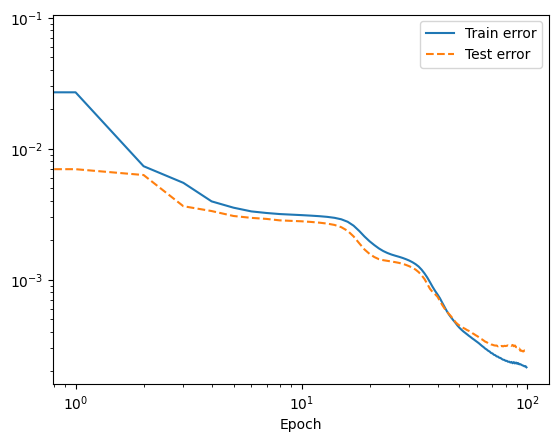

In [45]:
plt.plot(forward_model_mlp_avg.train_error,label='Train error')
plt.plot(forward_model_mlp_avg.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Script error in avg shots

In [46]:
#first we need to find the avg shots with the values close to FTL (o2=35000, o3=0, and o4=-4.5e6)
df_input_avg[(df_input_avg['order2']==35000) & (df_input_avg['order3']==1000)]

,order2,order3,order4,goodness mean
180,35000.0,1000.0,-5200000.0,1.446236
181,35000.0,1000.0,-4900000.0,1.553617
182,35000.0,1000.0,-4600000.0,1.730719


In [47]:
#%%time
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#for example 168758
#shot_ftl=168758
#ref_index=df_input_reduced[df_input_reduced['shot number']==shot_ftl].index.values[0]
ref_index=182


time=int(df_time_200.max())#150
time_bins=len(df_time_200)-1#200
print(time)
print(time_bins)
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
c = 299792458 ## speed of light in m/s
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
intensity=df_spec_int_avg.loc[ref_index].to_numpy()
frequency=df_spec_freq_avg.loc[ref_index].to_numpy()
phase=df_spec_phase_avg.loc[ref_index].to_numpy()
p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
p_2 =copy.deepcopy(p_ref)

#get the dispersion values from this reference shot
o2_ref=df_input_avg.loc[ref_index]['order2']
o3_ref=df_input_avg.loc[ref_index]['order3']
o4_ref=df_input_avg.loc[ref_index]['order4']

script_error_avg=[]
for shot_j in range(len(df_input_avg)):
    p_2 =copy.deepcopy(p_ref) #fresh copy every time
    #desired pulse
    #shot_j=50
    o2_final=df_input_avg.loc[shot_j]['order2']
    o3_final=df_input_avg.loc[shot_j]['order3']
    o4_final=df_input_avg.loc[shot_j]['order4']

    #add dispersion
    p_2.dispersion(2,o2_final-o2_ref)
    p_2.dispersion(3,o3_final-o3_ref)
    p_2.dispersion(4,o4_final-o4_ref)

    #shift the pulses so the peak at the center
    p2_s=shift_pulse(p_2.intensity)
    pmeas_s=shift_pulse(df_pulse_200_avg.iloc[shot_j]) #measured shot 

    #mae error
    error=abs(p2_s-pmeas_s)
    error=error.sum()/len(p2_s)
    script_error_avg.append(error)
script_error_avg=np.array(script_error_avg)

150
200


/tmp/ipykernel_109847/2247866517.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'Impact average shots (FWD models)')

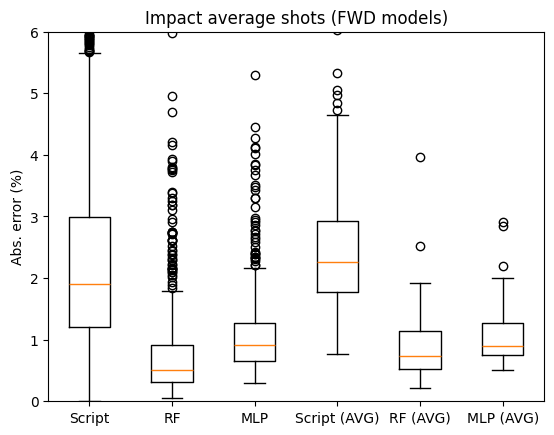

In [48]:
error_dist=[100*script_error,
            100*df_error_forward_rf,
           100*error_fwd_model_mlp,
            100*script_error_avg,
           100*df_error_forward_rf_avg,
           100*error_fwd_model_mlp_avg]
labels=['Script','RF','MLP','Script (AVG)','RF (AVG)','MLP (AVG)']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('Impact average shots (FWD models)')

         Error Dataset   Model
0    10.572439     All  Script
1     7.685112     All  Script
2     7.530497     All  Script
3     5.689584     All  Script
4     5.241778     All  Script
..         ...     ...     ...
97    0.953270     Avg     MLP
98    1.253326     Avg     MLP
99    0.756396     Avg     MLP
100   0.898119     Avg     MLP
101   1.412298     Avg     MLP

[4889 rows x 3 columns]


(0.0, 4.0)

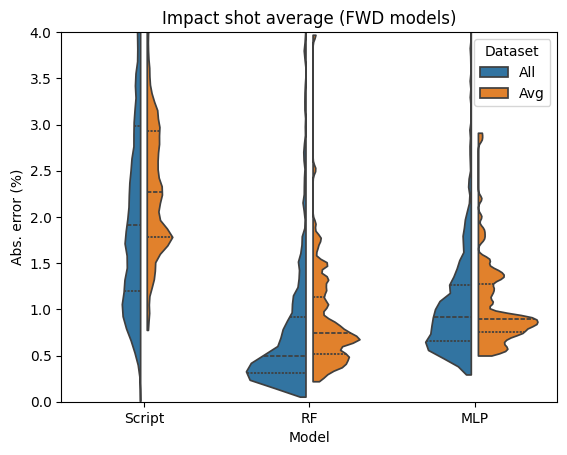

In [49]:
df_plot=pd.DataFrame({'Error':100*pd.Series(script_error),'Dataset':'All','Model':'Script'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'All','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'All','Model':'MLP'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*pd.Series(script_error_avg),'Dataset':'Avg','Model':'Script'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_avg,'Dataset':'Avg','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_avg,'Dataset':'Avg','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Model',y='Error',hue='Dataset',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
plt.ylabel('Abs. error (%)')
plt.xlabel('Model')
plt.title('Impact shot average (FWD models)')
plt.ylim(0,4)

         Error Dataset     Model
0    10.572439     All  Analytic
1     7.685112     All  Analytic
2     7.530497     All  Analytic
3     5.689584     All  Analytic
4     5.241778     All  Analytic
..         ...     ...       ...
97    0.953270     Avg       MLP
98    1.253326     Avg       MLP
99    0.756396     Avg       MLP
100   0.898119     Avg       MLP
101   1.412298     Avg       MLP

[4889 rows x 3 columns]


(0.0, 4.0)

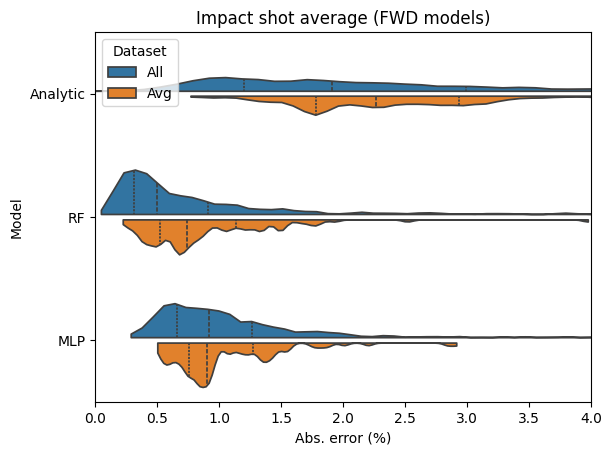

In [50]:
df_plot=pd.DataFrame({'Error':100*pd.Series(script_error),'Dataset':'All','Model':'Analytic'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'All','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'All','Model':'MLP'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*pd.Series(script_error_avg),'Dataset':'Avg','Model':'Analytic'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_avg,'Dataset':'Avg','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_avg,'Dataset':'Avg','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Error',y='Model',hue='Dataset',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
#plt.ylabel('Model')
plt.title('Impact shot average (FWD models)')
plt.xlim(0,4)

### Impact of dataset size

In [51]:
def drop_shots(drop_factor,df_input,df_time):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [52]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 1494
The datasize is no: 1087
The datasize is no: 517


In [53]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=models_tools.split_dataset_roundtrip(df_input_subset_1500,df_time_subset_1500,rand_split=False)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=models_tools.split_dataset_roundtrip(df_input_subset_1k,df_time_subset_1k,rand_split=False)
X_train_500, X_test_500, y_train_500, y_test_500=models_tools.split_dataset_roundtrip(df_input_subset_500,df_time_subset_500,rand_split=False)

In [54]:
#Training the Random Forest forward models
forward_model_rf_1500,df_error_forward_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k,df_error_forward_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500,df_error_forward_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

In [55]:
#Training the MLP forward models
forward_model_mlp_1500=models_fcnn.FWmodelNN(X_train_1500,y_train_1500,X_test_1500,y_test_1500,device)
forward_model_mlp_1500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1500=forward_model_mlp_1500.predict(X_test_1500)
error_fwd_model_mlp_1500=forward_model_mlp_1500.error_calc_mae()
print()

forward_model_mlp_1k=models_fcnn.FWmodelNN(X_train_1k,y_train_1k,X_test_1k,y_test_1k,device)
forward_model_mlp_1k.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1k=forward_model_mlp_1k.predict(X_test_1k)
error_fwd_model_mlp_1k=forward_model_mlp_1k.error_calc_mae()

print()
forward_model_mlp_500=models_fcnn.FWmodelNN(X_train_500,y_train_500,X_test_500,y_test_500,device)
forward_model_mlp_500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_500=forward_model_mlp_500.predict(X_test_500)
error_fwd_model_mlp_500=forward_model_mlp_500.error_calc_mae()

Finished epoch 0,latest loss 0.025595299899578094
Finished epoch 20,latest loss 0.0006516202702187002
Finished epoch 40,latest loss 0.0005132803344167769
Finished epoch 60,latest loss 0.00042913955985568464
Finished epoch 80,latest loss 0.0003606748068705201
Finished epoch 99,latest loss 0.00035136908991262317
Total time taken to train the model: 30.72s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.03686199337244034
Finished epoch 20,latest loss 0.0007156608044169843
Finished epoch 40,latest loss 0.0006022337474860251
Finished epoch 60,latest loss 0.0005546389147639275
Finished epoch 80,latest loss 0.0005260357866063714
Finished epoch 99,latest loss 0.0005149127100594342
Total time taken to train the model: 21.22s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.06014441326260567
Finished epoch 20,latest loss 0.0014543759170919657
Finished epoch 40,latest loss 0.0007391448016278446
Finished epoch 60,latest loss 0.0005081198760308325
Finished epo

/tmp/ipykernel_109847/3388916537.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


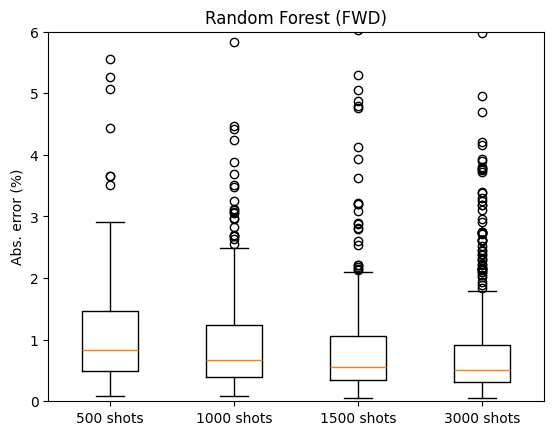

/tmp/ipykernel_109847/3388916537.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


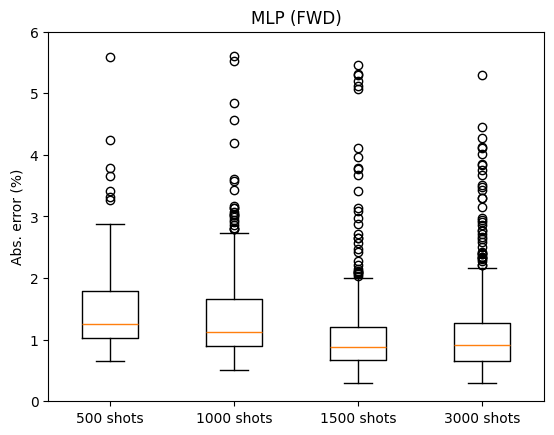

In [56]:
error_dist=[100*df_error_forward_rf_500,
            100*df_error_forward_rf_1k,
            100*df_error_forward_rf_1500,
            100*df_error_forward_rf]
labels=['500 shots','1000 shots','1500 shots','3000 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('Random Forest (FWD)')
plt.show()

error_dist=[100*error_fwd_model_mlp_500,
            100*error_fwd_model_mlp_1k,
            100*error_fwd_model_mlp_1500,
            100*error_fwd_model_mlp]
labels=['500 shots','1000 shots','1500 shots','3000 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('MLP (FWD)')
plt.show()

        Error Dataset Model
0    0.643722     500    RF
1    1.620129     500    RF
2    1.042582     500    RF
3    0.691895     500    RF
4    0.276347     500    RF
..        ...     ...   ...
810  0.593033    3000   MLP
811  0.916323    3000   MLP
812  0.793905    3000   MLP
813  1.157614    3000   MLP
814  0.524696    3000   MLP

[3494 rows x 3 columns]


(0.0, 3.0)

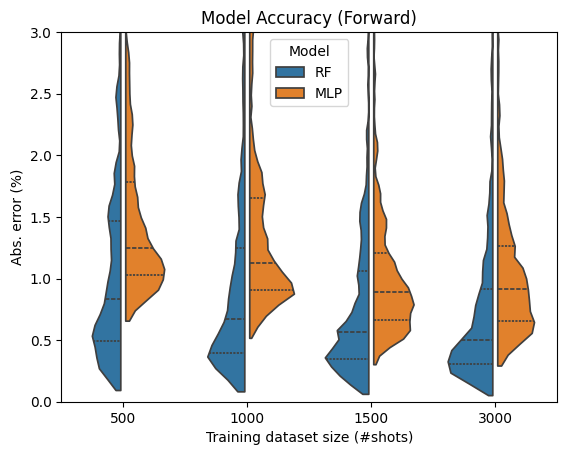

In [57]:
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
#sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.ylabel('Abs. error (%)')
plt.xlabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Forward)')
plt.ylim(0,3)
#plt.xlim(0,3)

        Error Dataset Model
0    0.643722     500    RF
1    1.620129     500    RF
2    1.042582     500    RF
3    0.691895     500    RF
4    0.276347     500    RF
..        ...     ...   ...
810  0.593033    3000   MLP
811  0.916323    3000   MLP
812  0.793905    3000   MLP
813  1.157614    3000   MLP
814  0.524696    3000   MLP

[3494 rows x 3 columns]


(0.0, 3.0)

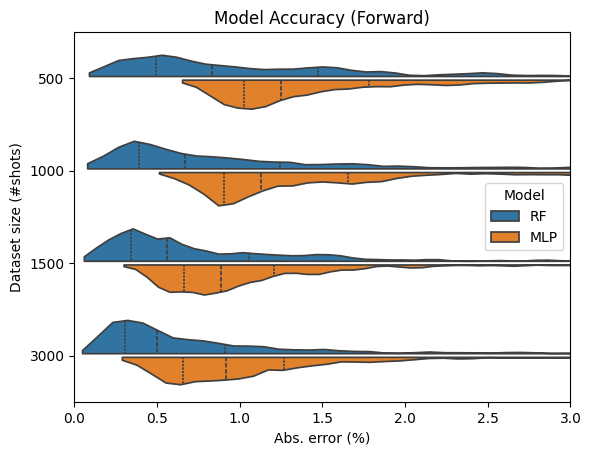

In [58]:
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

#sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Dataset size (#shots)')
plt.title('Model Accuracy (Forward)')
#plt.ylim(0,3)
plt.xlim(0,3)

       Analytic    Linear        RF       MLP
0     10.572439  1.816867  0.339681  0.659057
1      7.685112  1.268100  0.260936  0.559445
2      7.530497  2.881495  3.897119  3.840073
3      5.689584  3.450849  1.187995  2.038574
4      5.241778  0.957061  0.627136  0.847604
...         ...       ...       ...       ...
2711   2.519960       NaN       NaN       NaN
2712   2.444384       NaN       NaN       NaN
2713   2.545545       NaN       NaN       NaN
2714   2.472945       NaN       NaN       NaN
2715   2.440944       NaN       NaN       NaN

[2716 rows x 4 columns]
        Error Dataset Model
0    0.643722     500    RF
1    1.620129     500    RF
2    1.042582     500    RF
3    0.691895     500    RF
4    0.276347     500    RF
..        ...     ...   ...
810  0.593033    3000   MLP
811  0.916323    3000   MLP
812  0.793905    3000   MLP
813  1.157614    3000   MLP
814  0.524696    3000   MLP

[3494 rows x 3 columns]


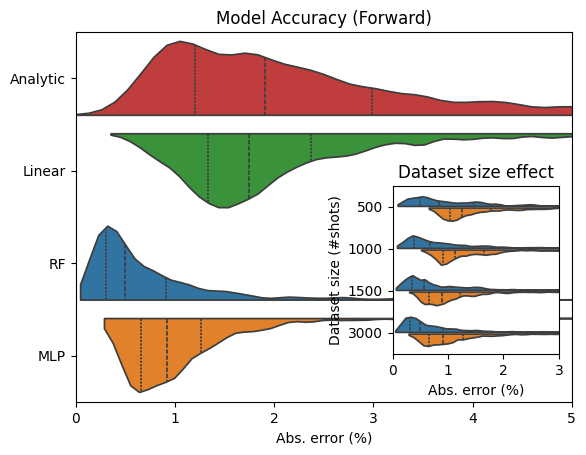

In [59]:
fig = plt.figure() #fig needed to add_axes later

df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)


#inset plot
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

ax = fig.add_axes([0.62, 0.21, 0.26, 0.35], facecolor='white') #[left, bottom, width, height]
#sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Dataset size (#shots)')
plt.title('Dataset size effect')
#plt.ylim(0,3)
plt.xlim(0,3)
ax.get_legend().remove()

## Different days

In [60]:
#load the dataset from a different day

In [61]:
filename_2='datasets/galadriel_dataset_25_03_13_high_res.h5'
df_input_dd,df_time_val_dd,df_time_dd,df_freq_val_dd,df_freq_int_dd = data_analysis.read_dataset(filename_2)

Input DF
       shot number   order2   order3     order4  goodness
0           200378  34400.0 -23000.0 -5500000.0  0.878217
1           200379  34400.0 -23000.0 -5500000.0  1.025813
2           200380  34400.0 -23000.0 -5500000.0  0.853794
3           200381  34400.0 -23000.0 -5200000.0  1.003888
4           200382  34400.0 -23000.0 -5200000.0  1.022131
...            ...      ...      ...        ...       ...
15428       215808  35400.0  28000.0 -4000000.0  1.267706
15429       215809  35400.0  28000.0 -4000000.0  1.275014
15430       215810  35400.0  28000.0 -3700000.0  1.076831
15431       215811  35400.0  28000.0 -3700000.0  1.062826
15432       215812  35400.0  28000.0 -3700000.0  1.065211

[15433 rows x 5 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.4886

In [62]:
df_input_dd.describe()

,shot number,order2,order3,order4,goodness
count,15433.000000,15433.000000,15433.000000,1.543300e+04,15433.000000
mean,208094.927363,34899.996760,2498.250502,-4.600039e+06,1.080693
std,4455.539560,302.755671,15149.603777,6.000097e+05,0.164811
min,200378.000000,34400.000000,-23000.000000,-5.500000e+06,0.680889
25%,204237.000000,34650.000000,-11000.000000,-5.200000e+06,0.958479
50%,208095.000000,34900.000000,2500.000000,-4.600000e+06,1.055294
75%,211953.000000,35150.000000,16000.000000,-4.000000e+06,1.205683
max,215812.000000,35400.000000,28000.000000,-3.700000e+06,1.731142


In [63]:
filename_pulse_2='datasets/pulse_250313.h5'
df_time_dd_200=pd.read_hdf(filename_pulse_2,'df_time_200')
df_pulse_dd_200=pd.read_hdf(filename_pulse_2,'df_pulse_200')
t_200_dd=df_time_dd_200.to_numpy()

## Drop shots with bad goodness¶

In [64]:
df_input_dd_reduced=df_input_dd[df_input_dd['goodness']>goodness_val]

good_shots_list_dd=df_input_dd_reduced.index.values
#print(good_shots_list)
df_pulse_dd_200_reduced=df_pulse_dd_200.iloc[good_shots_list_dd]
#df_spec_freq_reduced=df_spec_freq.iloc[good_shots_list]
#df_spec_int_reduced=df_spec_int.iloc[good_shots_list]
#df_spec_phase_reduced=df_spec_phase.iloc[good_shots_list]

#reset the index
df_input_dd_reduced.reset_index(inplace=True,drop=True)
df_pulse_dd_200_reduced.reset_index(inplace=True,drop=True)
#df_spec_freq_reduced.reset_index(inplace=True,drop=True)
#df_spec_int_reduced.reset_index(inplace=True,drop=True)
#df_spec_phase_reduced.reset_index(inplace=True,drop=True)

In [65]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163188,34400.0,-23000.0,-4900000.0,1.418891
3,163189,34400.0,-23000.0,-4600000.0,1.335844
4,163192,34400.0,-23000.0,-4600000.0,1.333817
...,...,...,...,...,...
2711,172480,35400.0,19000.0,-5500000.0,1.330710
2712,172481,35400.0,19000.0,-5500000.0,1.365691
2713,172482,35400.0,19000.0,-5500000.0,1.357783
2714,172483,35400.0,19000.0,-5500000.0,1.319961


In [66]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train_dd, X_test_dd, y_train_dd, y_test_dd=models_tools.split_dataset_roundtrip(df_input_dd_reduced,df_pulse_dd_200_reduced,rand_split=False)

### TRain RF forward

In [67]:
%%time
forward_model_rf_dd,df_error_forward_rf_dd=train_rf_forward(X_train_dd, X_test_dd, y_train_dd, y_test_dd)

CPU times: user 1.76 s, sys: 116 ms, total: 1.88 s
Wall time: 1.87 s


### Use the RF trained on 250313 and use it to predict 240918

In [68]:
y_predict_forward_dd=models_rf.make_rf_prediction(forward_model_rf_dd,X_test)

#study the erro distribution
y_test_reset=y_test.reset_index(drop=True)
df_error_forward_rf_notrain=abs(y_test_reset-y_predict_forward_dd)
df_error_forward_rf_notrain=df_error_forward_rf_notrain.sum(axis=1)/y_test.shape[1] #sum error / num columns

       250313    240918  240918\n (pretrained)
0    0.182461  0.339681               2.074234
1    0.262120  0.260936               1.224666
2    0.204000  3.897119               5.468787
3    0.091685  1.187995               5.534680
4    0.227041  0.627136               2.194128
..        ...       ...                    ...
810       NaN  0.346261               2.017151
811       NaN  0.648639               0.774160
812       NaN  0.877197               2.637364
813       NaN  0.728918               1.401701
814       NaN  0.270659               1.169239

[815 rows x 3 columns]


([0, 1, 2],
 [Text(0, 0, '250313'),
  Text(0, 1, '240918'),
  Text(0, 2, '240918\n (pretrained)')])

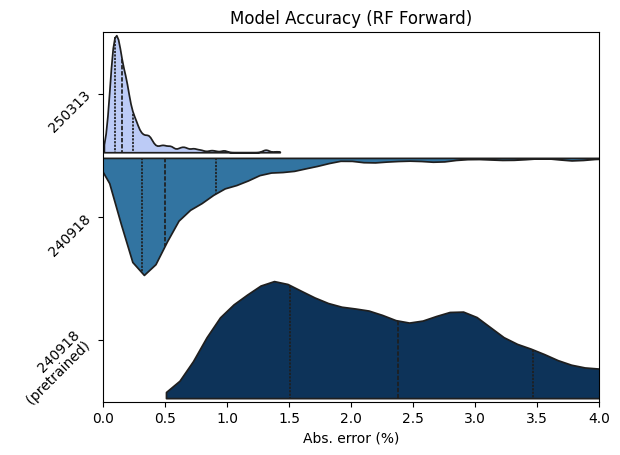

In [71]:
df_plot=pd.DataFrame({'250313':100*df_error_forward_rf_dd,
                      '240918':100*df_error_forward_rf,
                      '240918\n (pretrained)':100*df_error_forward_rf_notrain})
#df_plot=pd.DataFrame({'240918 using \n pretrained model':100*df_error_forward_rf_notrain,
#                      '250313':100*df_error_forward_rf_dd})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=1,bw_adjust=.4,split=True,orient='h',width=0.95,
#              palette=['tab:orange','tab:blue','tab:green'])
              palette=['#b3c6ff', 'tab:blue', '#003366'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (RF Forward)')
plt.xlim(0,4)
plt.yticks(rotation=45)